**Project Check-in 2**

In [ ]:
%pip install scikit-lego
%pip install seaborn
%pip install nbstripout
%nbstripout --install

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


df = pd.read_csv("./dataset.csv")

In [3]:
# CLEAN DATA

# Drop all duplicates (need to remove the first column because these are just indices)
revised_df = df.drop(columns='Unnamed: 0').drop_duplicates(subset=['track_id','album_name','artists','track_name'])

# Drop NaN values
# NEED TO FIGURE OUT WHETHER THIS IS WORTH IT BC ONLY ARTISTS/ALBUM_NAME/TRACK_NAME ARE NAN

revised_df.dropna(axis=0,inplace=True)

revised_df.drop(columns=['track_id', 'artists', 'album_name', 'track_name'], inplace=True)
columns = revised_df.columns
le = LabelEncoder()
revised_df['track_genre'] = le.fit_transform(revised_df['track_genre'])

scaler = StandardScaler()
revised_df = scaler.fit_transform(revised_df)
revised_df = pd.DataFrame(revised_df, columns=columns)

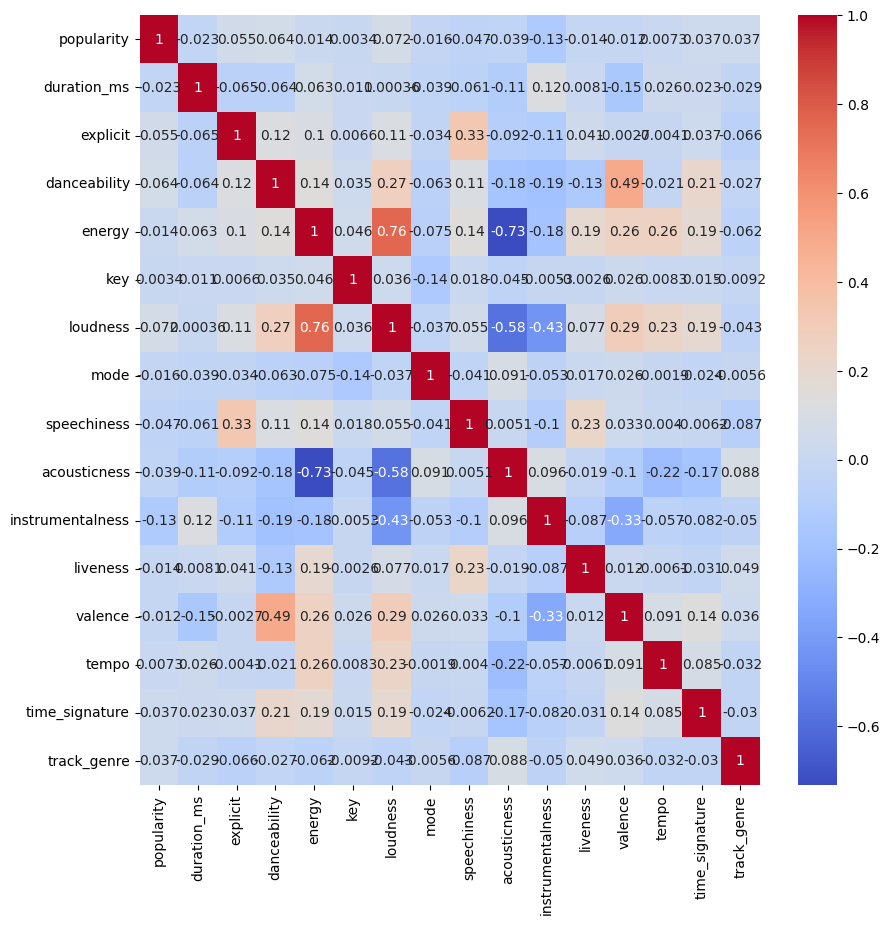

In [4]:
# Look at linear correlations between features
corr_matrix = revised_df.corr(method='pearson')
plt.figure(figsize=(10 , 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


1. and 2. : We are using loudness as a predictor of energy because they have a high linear correlation coefficient, as seen in the above graphic.

(-6.0, 3.0)

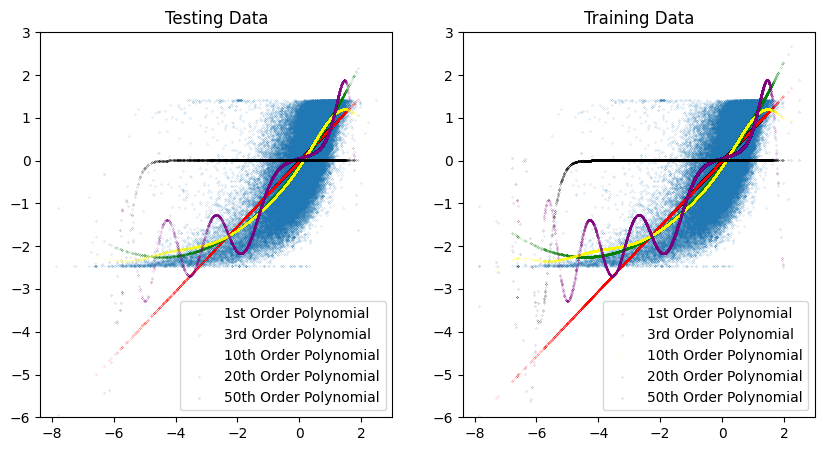

In [5]:
np.random.seed(1000)

x_train, x_test, y_train, y_test = train_test_split(revised_df['loudness'], revised_df['energy'], test_size=0.2)

polynomial_orders = [(1, "1st"), (3, "3rd"), (10, "10th"), (20, "20th"), (50, "50th")]
colors = ['red', 'green', 'yellow', 'purple', 'black']
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(x_train, y_train, s=0.01)
ax[1].scatter(x_train, y_train, s=0.01)

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()


sorted_train_indices = np.argsort(x_train)
sorted_test_indices = np.argsort(x_test)
x_train = x_train[sorted_train_indices]
x_test = x_test[sorted_test_indices]
y_train = y_train[sorted_train_indices]
y_test = y_test[sorted_test_indices]

poly_reg_model = LinearRegression()

regression_data = []

for ind,i in enumerate(polynomial_orders):
    poly = PolynomialFeatures(degree=i[0], include_bias=False)
    poly_features_train = poly.fit_transform(x_train.reshape(-1,1))
    poly_features_test = poly.fit_transform(x_test.reshape(-1,1))
    poly_reg_model.fit(poly_features_train, y_train)

    energy_predicted_test = poly_reg_model.predict(poly_features_test)
    energy_predicted_train = poly_reg_model.predict(poly_features_train)

    ax[0].scatter(x_test, energy_predicted_test, c=colors[ind], label=f"{i[1]} Order Polynomial", s=0.01)
    ax[1].scatter(x_train, energy_predicted_train, c=colors[ind], label=f"{i[1]} Order Polynomial", s=0.01)
    regression_data.append([i,energy_predicted_train, energy_predicted_test])

# Both graphs have a scatterplot of the training data underneath the regression curves
ax[0].legend()
ax[1].legend()
ax[0].set_title("Testing Data")
ax[1].set_title("Training Data")
ax[0].set_ylim(-6,3)
ax[1].set_ylim(-6,3)

4. Here we see evidence of underfitting for the 1st, 3rd, and to a lesser degree, 10th order polynomial regressions. This is shownby the fact that those polynomials have high error on even the training data.  The 20th and 50th order show signs of overfitting, namely, high-frequency components present when the underlying trend is clearly dominated by low-frequency signals.

1st Order Polynomial:
    RMSE for Training Data: 0.6515607320666389
    RMSE for Testing Data: 0.6505317330994379
3rd Order Polynomial:
    RMSE for Training Data: 0.6150049906076769
    RMSE for Testing Data: 0.6156649809737509
10th Order Polynomial:
    RMSE for Training Data: 0.6121803280236077
    RMSE for Testing Data: 0.6125447572084198
20th Order Polynomial:
    RMSE for Training Data: 0.7005068005571438
    RMSE for Testing Data: 2.346577401422845
50th Order Polynomial:
    RMSE for Training Data: 0.9968788752777263
    RMSE for Testing Data: 220.89590342071426


Text(0.5, 1.0, 'Error Metrics for Testing and Training Data')

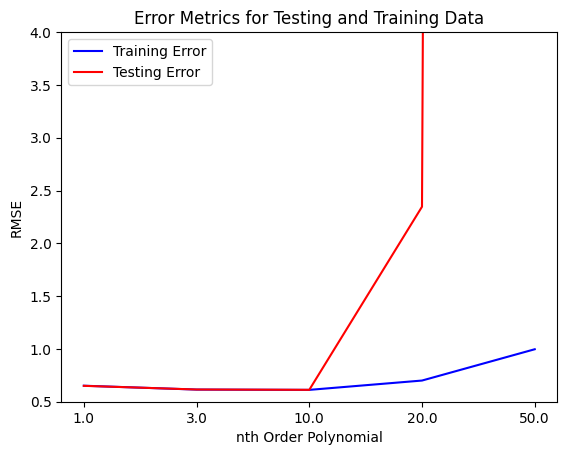

In [6]:
error_data = []

for ind,data in enumerate(regression_data):
    rmse_train = np.sqrt(mean_squared_error(y_train, data[1]))
    rmse_test = np.sqrt(mean_squared_error(y_test, data[2]))
    print(f"{data[0][1]} Order Polynomial:")
    print(f"    RMSE for Training Data: {rmse_train}")
    print(f"    RMSE for Testing Data: {rmse_test}")
    error_data.append([data[0][0],rmse_train,rmse_test])

error_data = np.array(error_data)

plt.plot(error_data[:,0].astype(str), error_data[:,1], label="Training Error", color="blue")
plt.plot(error_data[:,0].astype(str), error_data[:,2], label="Testing Error", color="red")
plt.legend()
plt.ylim(0.5,4)
plt.xlabel("nth Order Polynomial")
plt.ylabel("RMSE")
plt.title("Error Metrics for Testing and Training Data")

(-6.0, 3.0)

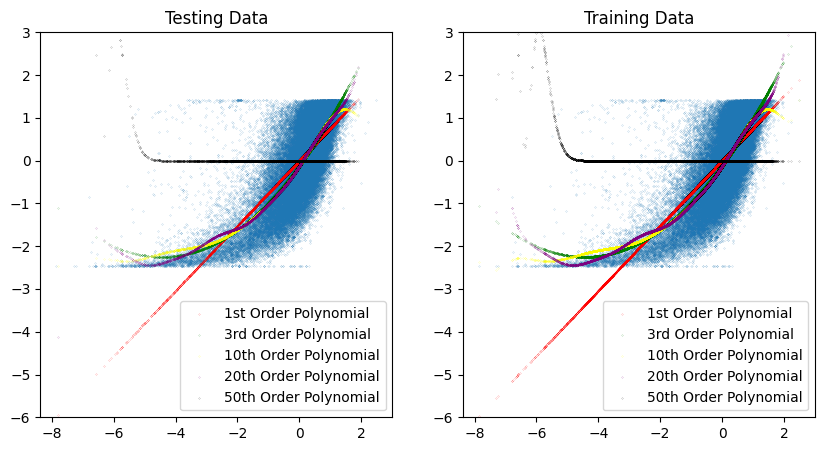

In [7]:
ridge = Ridge()

polynomial_orders = [(1, "1st"), (3, "3rd"), (10, "10th"), (20, "20th"), (50, "50th")]
colors = ['red', 'green', 'yellow', 'purple', 'black']
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(x_train, y_train, s=0.01)
ax[1].scatter(x_train, y_train, s=0.01)

ridge_regression_data = []

for ind,i in enumerate(polynomial_orders):
    poly = PolynomialFeatures(degree=i[0], include_bias=False)
    poly_features_train = poly.fit_transform(x_train.reshape(-1,1))
    poly_features_test = poly.fit_transform(x_test.reshape(-1,1))
    ridge.fit(poly_features_train, y_train)

    energy_predicted_test = ridge.predict(poly_features_test)
    energy_predicted_train = ridge.predict(poly_features_train)

    ax[0].scatter(x_test, energy_predicted_test, c=colors[ind], label=f"{i[1]} Order Polynomial", s=0.01)
    ax[1].scatter(x_train, energy_predicted_train, c=colors[ind], label=f"{i[1]} Order Polynomial", s=0.01)
    ridge_regression_data.append([i,energy_predicted_train, energy_predicted_test])

# Both graphs have a scatterplot of the training data underneath the regression curves
ax[0].legend()
ax[1].legend()
ax[0].set_title("Testing Data")
ax[1].set_title("Training Data")
ax[0].set_ylim(-6,3)
ax[1].set_ylim(-6,3)

1st Order Polynomial:
    RMSE for Training Data: 0.6515607321524421
    RMSE for Testing Data: 0.6505316607044392
3rd Order Polynomial:
    RMSE for Training Data: 0.615004990948598
    RMSE for Testing Data: 0.6156647508729067
10th Order Polynomial:
    RMSE for Training Data: 0.6121803307370794
    RMSE for Testing Data: 0.6125449485208418
20th Order Polynomial:
    RMSE for Training Data: 0.614217056634005
    RMSE for Testing Data: 0.6136557028952866
50th Order Polynomial:
    RMSE for Training Data: 1.0184459741306318
    RMSE for Testing Data: 161.87795961820774


Text(0.5, 1.0, 'Error Metrics for Testing and Training Data')

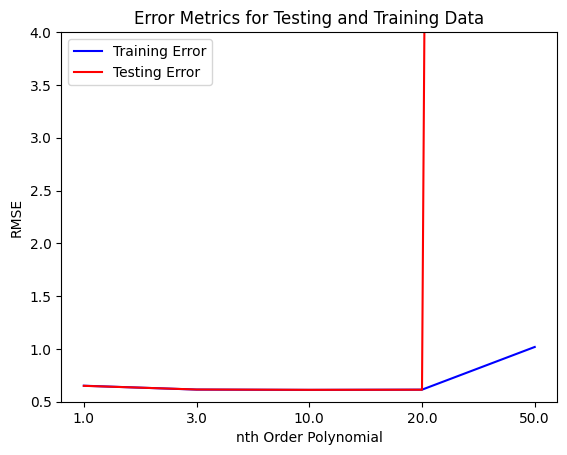

In [8]:
error_data = []

for ind,data in enumerate(ridge_regression_data):
    rmse_train = np.sqrt(mean_squared_error(y_train, data[1]))
    rmse_test = np.sqrt(mean_squared_error(y_test, data[2]))
    print(f"{data[0][1]} Order Polynomial:")
    print(f"    RMSE for Training Data: {rmse_train}")
    print(f"    RMSE for Testing Data: {rmse_test}")
    error_data.append([data[0][0],rmse_train,rmse_test])

error_data = np.array(error_data)

plt.plot(error_data[:,0].astype(str), error_data[:,1], label="Training Error", color="blue")
plt.plot(error_data[:,0].astype(str), error_data[:,2], label="Testing Error", color="red")
plt.legend()
plt.ylim(0.5,4)
plt.xlabel("nth Order Polynomial")
plt.ylabel("RMSE")
plt.title("Error Metrics for Testing and Training Data")

5. With L2 regularization, the model does worse on training data and better on testing data than the regression without regularization, as expected, because overfitting is reduced.